In [1]:
import pandas as pd
import numpy as np
import sklearn

# Loading Data
* Load the data
* Split features from predictor class
* Encode features
* Filter outliers

In [2]:
raw_data = pd.read_csv('data/house-votes-84.data.txt', \
    names=['party'] + ['v%02d'%x for x in range(16)])
raw_data.head()

,party,v00,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,v11,v12,v13,v14,v15
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [3]:
# Split the data into party affiliation (output variable) and votes (features)
party = raw_data['party']
votes = raw_data.drop('party', axis=1)

In [4]:
print(f'# Entries {raw_data.shape[0]}, # Features {raw_data.shape[1]-1}')
print(f'\nClass distribution: \n{party.value_counts()}')
print(f'\nFeature distribution: \n{pd.Series(votes.values.flatten()).value_counts()}')

# Entries 435, # Features 16

Class distribution: 
democrat      267
republican    168
Name: party, dtype: int64

Feature distribution: 
y    3421
n    3147
?     392
dtype: int64


In [5]:
# Map the votes to easy to process feature values
features = votes.apply(lambda x: x.map({'n':0, '?':1, 'y':2}), axis=1)
features.head()

,v00,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,v11,v12,v13,v14,v15
0,0,2,0,2,2,2,0,0,0,2,1,2,2,2,0,2
1,0,2,0,2,2,2,0,0,0,0,0,2,2,2,0,1
2,1,2,2,1,2,2,0,0,0,0,2,0,2,2,0,0
3,0,2,2,0,1,2,0,0,0,0,2,0,2,0,0,2
4,2,2,2,0,2,2,0,0,0,0,2,1,2,2,2,2


In [6]:
voting_treshold = 4

# Filter votes, that have than half of missing votes
# (keep those that have less than 8 missing votes)
nmissing_votes = (features == 1).sum(axis=1)
keep = nmissing_votes <= voting_treshold

print(f'Dropping {keep.shape[0] - keep.sum()} rows because to \
more than {voting_treshold} missing votes!')

party = party[keep]
votes = votes[keep]
features = features[keep]

Dropping 14 rows because to     more than 4 missing votes!


# Handle missing values
Two datasets will be generated, using two different methods to handle the missing data

* Process each vote/column seperatly and fill entries based on the most common value of the 5 closest neighbours. Neighbours are calculated has most similar encoding.
* Random selection of yes or no votes

In [18]:
def nn_fill(table, N=5, missing_value=0):
    # Store results here
    cleaned = table.copy()

    for column_idx in range(table.shape[1]):

        has_missing = (table.iloc[:, column_idx] == missing_value)
        print(f'Found #{has_missing.sum()} missing valuesin column \
        {column_idx}. Start filling them ...')

        missing = table[has_missing].drop(table.columns[column_idx], axis=1)
        # Get all neighbours, dropping the column that needs prediction
        neighbours = table[~has_missing].drop(table.columns[column_idx], axis=1)

        # For each missing, calculate its neighbour distance
        for i, s in missing.iterrows():
            # Calculate the distance as the absolute numeric difference
            distance = neighbours.apply(lambda x: abs(x - s).sum(), axis=1)

            # Find the most common value among the N closest neighbours
            most_common = table.loc[distance.sort_values()[0:N].index, \
                                    table.columns[column_idx]].mode().values[0]

            #print(f'for row {i} we found the most common value to be {most_common}')
            cleaned.loc[i, table.columns[column_idx]] = most_common

    print('All done!')
    
    return cleaned

def random_fill(table, seed=42, missing_value=0, values=[-1, 1]):
    # Initalize random generator
    np.random.seed(seed)
    
    # Which rows and colums need filling
    missing_r, missing_col = np.where(features.values == missing_value)
    
    # Generate some random sequence
    rand_idx = np.random.randint(0, len(values), size=missing_r.size)

    # Store result here
    random_fill = features.copy()
    for vote, row, column in zip(rand_idx, missing_r, missing_col):
        random_fill.iloc[row, column] = values[vote]
        
    return random_fill

In [8]:
# Number of nearest neighbours to use
cleaned_features = nn_fill(features, N=5, missing_value=1)
random_features = random_fill(features, seed=8888, missing_value=1, values=[0, 2])

Found #5 missing valuesin column             0. Start filling them ...
Found #39 missing valuesin column             1. Start filling them ...
Found #6 missing valuesin column             2. Start filling them ...
Found #6 missing valuesin column             3. Start filling them ...
Found #10 missing valuesin column             4. Start filling them ...
Found #6 missing valuesin column             5. Start filling them ...
Found #8 missing valuesin column             6. Start filling them ...
Found #8 missing valuesin column             7. Start filling them ...
Found #18 missing valuesin column             8. Start filling them ...
Found #3 missing valuesin column             9. Start filling them ...
Found #11 missing valuesin column             10. Start filling them ...
Found #22 missing valuesin column             11. Start filling them ...
Found #18 missing valuesin column             12. Start filling them ...
Found #10 missing valuesin column             13. Start filling them

# Building a classifier
* Split data into training and test set
* Train a Naive Bayes Classifier with bernoulli distribution

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Use 20% for testing
training_test_ratio = 0.2

train_idx, test_idx = train_test_split(party.index, test_size=training_test_ratio, random_state=1001)

In [10]:
# Train classifier
data = cleaned_features
#data = random_features

clf = BernoulliNB().fit(data.loc[train_idx], party.loc[train_idx])

In [11]:
# Perform prediction
prediction = clf.predict(data.loc[test_idx])
truth = party.loc[test_idx].values

# Evaluate prediction quality

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

/Users/manuel.pasieka/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


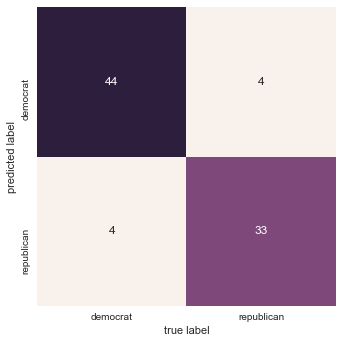

In [13]:
labels = ['democrat', 'republican']
mat = confusion_matrix(truth, prediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

In [14]:
accurracy = (mat[0, 0] + mat[1, 1]) / mat.sum()
print(f'Accuracy {accurracy*100.0:2.0f}%')

Accuracy 91%


# Cross Validation
Use cross validation with a 5 fold to estimate accuracy, comparing the different variations of classifiers, and data sets.

In [15]:
from sklearn.model_selection import cross_val_score

F = 5 

nn_scores_b = cross_val_score(BernoulliNB(), cleaned_features, party, cv=F)
rand_scores_b = cross_val_score(BernoulliNB(), random_features, party, cv=F)

nn_scores_g = cross_val_score(GaussianNB(), cleaned_features, party, cv=F)
rand_scores_g = cross_val_score(GaussianNB(), random_features, party, cv=F)

nn_scores_m = cross_val_score(MultinomialNB(), cleaned_features, party, cv=F)
rand_scores_m = cross_val_score(MultinomialNB(), random_features, party, cv=F)

scores = [nn_scores_b, rand_scores_b, nn_scores_g, rand_scores_g, nn_scores_m, rand_scores_m]
scores_labels = ['NN - Bernoulli', 'Random - Bernoulli', 'NN - Gausian', \
                 'Random - Gausian', 'NN - MultiN', 'Random - MultiN']

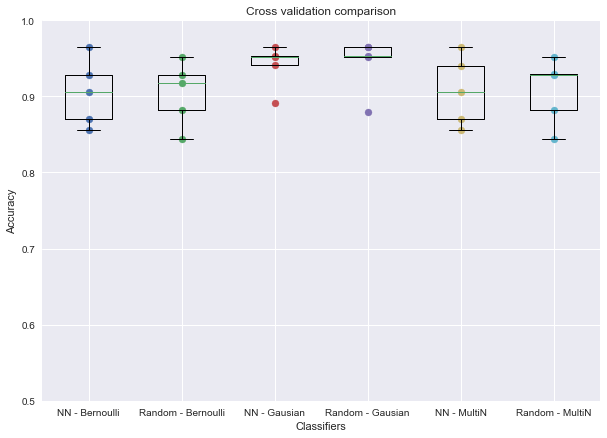

In [16]:
# Plot cross validation result
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
bp = axs.boxplot(scores, 0, labels=scores_labels, positions=range(len(scores)))
for i, sv in enumerate(scores):
    axs.scatter([i]*len(sv), sv)
axs.set_ylim(0.5, 1.0)
axs.set_xlabel('Classifiers')
axs.set_ylabel('Accuracy')
axs.set_title('Cross validation comparison')
plt.show()

In [17]:
for sn, sv in zip(scores_labels, scores):
    print(f'{sn}: mean {sv.mean():2.3f}, var {sv.var():2.3f}')

NN - Bernoulli: mean 0.905, var 0.002
Random - Bernoulli: mean 0.905, var 0.001
NN - Gausian: mean 0.940, var 0.001
Random - Gausian: mean 0.943, var 0.001
NN - MultiN: mean 0.907, var 0.002
Random - MultiN: mean 0.907, var 0.002
